In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import json

In [2]:
# Load up the patient data 
df = pd.read_csv('dataset.csv')

In [3]:
df

,patient_id,day,age,gender,bmi,smoker,heart_rate,bp_sys,bp_dia,spo2,glucose,creatinine,adherence,sleep_hours,exercise_mins,deteriorated_90d
0,1,1,63,Female,23.8,0,69,127,77,98.0,95,0.77,1,6.9,54,0.0
1,1,2,63,Female,28.4,0,70,118,78,97.9,104,0.80,1,7.2,57,0.0
2,1,3,63,Female,25.3,0,74,114,66,97.2,93,0.88,1,7.7,44,0.0
3,1,4,63,Female,25.1,0,70,119,83,98.6,88,0.65,1,6.4,51,0.0
4,1,5,63,Female,23.2,0,71,119,74,99.1,89,0.79,0,8.4,60,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,200,176,54,Female,24.3,0,67,114,74,98.1,94,0.68,1,5.9,64,0.0
35996,200,177,54,Female,25.9,0,69,115,76,97.5,90,0.85,1,6.6,37,0.0
35997,200,178,54,Female,25.0,0,68,113,69,97.9,93,0.72,1,7.9,57,0.0
35998,200,179,54,Female,24.1,0,72,116,78,98.5,89,0.80,1,8.2,38,0.0


In [4]:
# The goal is to create one single, summary row for each patient.
patient_features = []
patient_ids = df['patient_id'].unique()

for pid in patient_ids:
    patient_df = df[(df['patient_id'] == pid) & (df['day'] > 60) & (df['day'] <= 90)]
    
    # If a patient doesn't have a full 30 days in this window, skip them.
    if len(patient_df) < 30:
        continue

     # Grab the patient's basic info from their latest record.
    static_features = patient_df[['patient_id', 'age', 'gender', 'smoker', 'bmi']].iloc[-1].to_dict()
     # What were their average vital signs over this period?
    static_features['avg_hr'] = patient_df['heart_rate'].mean()
    static_features['avg_bp_sys'] = patient_df['bp_sys'].mean()
    static_features['avg_glucose'] = patient_df['glucose'].mean()
    static_features['avg_spo2'] = patient_df['spo2'].mean()
    
    # How stable were their vitals? Standard deviation can tell us about volatility.
    static_features['std_hr'] = patient_df['heart_rate'].std()
    static_features['std_bp_sys'] = patient_df['bp_sys'].std()

    time_axis = np.arange(len(patient_df))
    static_features['slope_hr'] = linregress(time_axis, patient_df['heart_rate']).slope
    static_features['slope_bp_sys'] = linregress(time_axis, patient_df['bp_sys']).slope
    static_features['slope_glucose'] = linregress(time_axis, patient_df['glucose']).slope

    # Let's also look at their lifestyle habits.
    static_features['adherence_rate'] = patient_df['adherence'].mean()
    static_features['avg_exercise'] = patient_df['exercise_mins'].mean()

    # This is what we want to predict: did their health get worse?
    static_features['target'] = patient_df['deteriorated_90d'].iloc[-1]
    patient_features.append(static_features)

In [5]:
model_df = pd.DataFrame(patient_features)
model_df['gender'] = model_df['gender'].apply(lambda x: 1 if x == 'Male' else 0)


In [6]:
print("Feature Engineering Completed")
print(model_df.head())

Feature Engineering Completed
   patient_id  age  gender  smoker   bmi     avg_hr  avg_bp_sys  avg_glucose  \
0           1   63       0       0  24.5  70.333333  120.233333    96.033333   
1           2   61       1       0  30.7  84.833333  151.033333   161.333333   
2           3   53       1       0  23.7  69.066667  117.833333    95.866667   
3           4   53       0       0  24.0  69.366667  117.933333    95.500000   
4           5   56       0       0  26.2  78.233333  147.100000   121.100000   

    avg_spo2    std_hr  std_bp_sys  slope_hr  slope_bp_sys  slope_glucose  \
0  97.950000  2.974992    3.953901 -0.024027     -0.111902       0.271635   
1  94.883333  3.630174    4.334969 -0.031368     -0.006452       0.214461   
2  97.946667  2.778406    4.119619  0.091657     -0.015350       0.189099   
3  98.106667  2.953471    4.653018 -0.073192     -0.021802       0.378865   
4  95.770000  3.430928    5.498276  0.133704      0.286318      -0.148832   

   adherence_rate  avg_exe

## Model Training

In [7]:
X = model_df.drop(columns=['patient_id', 'target'])
y = model_df['target']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [9]:
# Initialize and train the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
model.fit(X_train, y_train)

C:\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:03:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Make predictions on the test set

In [10]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1])

In [11]:
model_filename = 'chronic_patient_risk_model.joblib'
joblib.dump(model, model_filename)

['chronic_patient_risk_model.joblib']

In [12]:
columns_filename = 'model_columns.json'
with open(columns_filename, 'w') as f:
    json.dump(X_train.columns.tolist(), f)

## Evaluation Metrics

In [13]:
auroc = roc_auc_score(y_test, y_pred_proba)
auprc = average_precision_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Area Under ROC Curve (AUROC): {auroc:.4f}")
print(f"Area Under Precision-Recall Curve (AUPRC): {auprc:.4f}")

Area Under ROC Curve (AUROC): 0.8272
Area Under Precision-Recall Curve (AUPRC): 0.9712


## Visualization 

Cunfusion Matrix



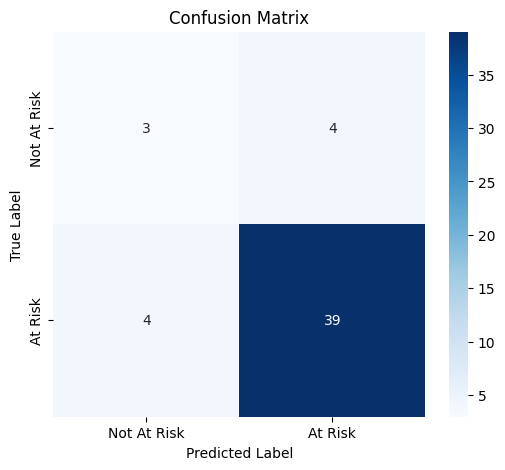

In [14]:
print("Cunfusion Matrix\n")
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not At Risk', 'At Risk'], yticklabels=['Not At Risk', 'At Risk'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

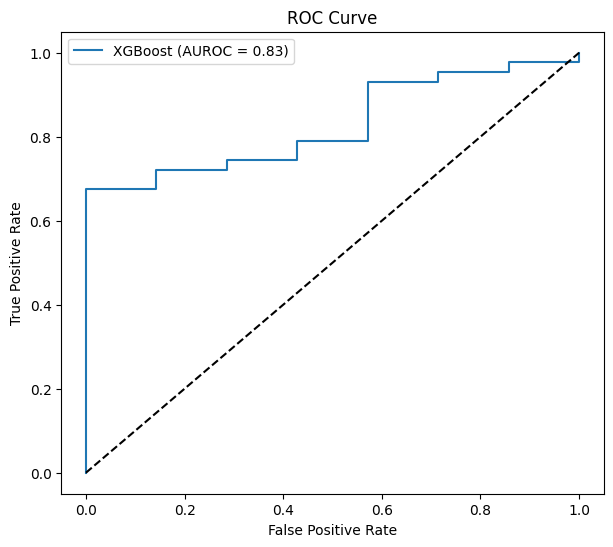

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUROC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## SHAP (SHapley Additive exPlanations)


What features matter most for all patients?


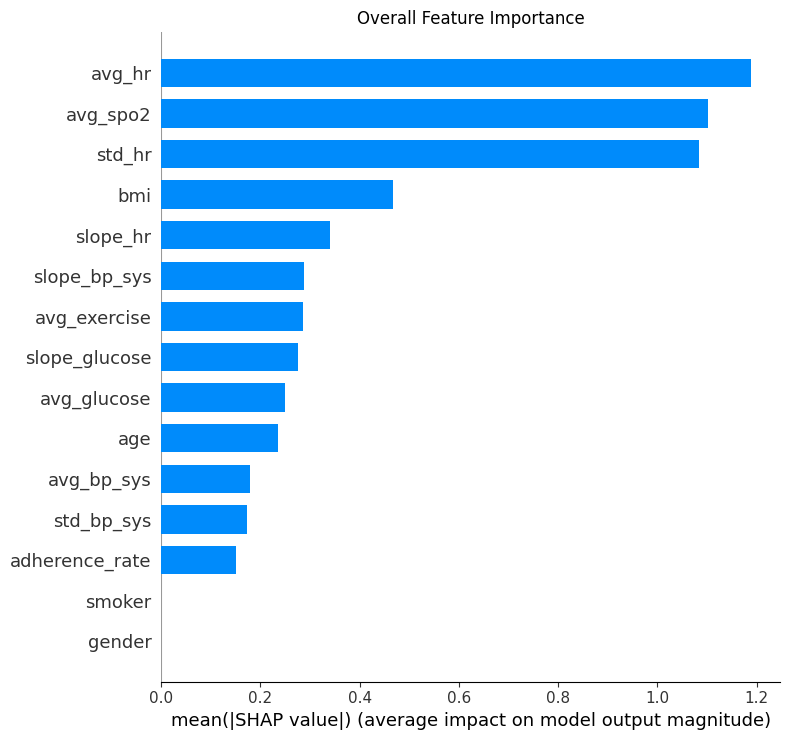

In [16]:
# Let's get the SHAP explainer ready to work with our model.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# This plot shows us which features have the biggest impact overall, across everyone.
print("\nWhat features matter most for all patients?")
plt.title("Overall Feature Importance")
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()